In [1]:
from functools import partial

import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import sklearn, sklearn.linear_model, sklearn.calibration
import torch

import loader
from models import MLPClassifier, DummyEstimator
import utils

split_ratio_test = 0.3
split_ratio_postproc = 0.1  # among all training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 38)

# This seed controls the randomness during pre-training (fixed)
seed_pretrain = 33

max_workers = 32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

data_dir = "data/acsincome"

In [2]:
## Load ACSIncome dataset from `folktables`
dataset_name = "ACSIncome2"

(inputs_df, labels, label_names, groups, group_names) = loader.cache_dataset(
    f"{data_dir}/acsincome2.pkl", lambda: loader.load_acsincome(
        data_dir,
        n_classes=2,
        sensitive_attr='SEX',
    ))
display(loader.dataset_stats(labels, label_names, groups, group_names))

n_classes = len(label_names)
n_groups = len(group_names)

inputs = np.array(inputs_df.values, dtype=np.float32, copy=True)
inputs_df.drop(columns=list(inputs_df.filter(regex=f'^SEX_')), inplace=True)
inputs_u = inputs_df.values.astype(np.float32)

Group,Male,Female
Target,,
<=50K,483923,566510
>50K,382812,231255


In [3]:
## Split data into (test + post-processing) and pre-training sets

(inputs_, inputs_pretrain, inputs_u_, inputs_u_pretrain, labels_,
 labels_pretrain, groups_,
 groups_pretrain) = sklearn.model_selection.train_test_split(
     inputs,
     inputs_u,
     labels,
     groups,
     test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
     random_state=seed_pretrain,
 )

# Encode the joint (A, Y) labels by flattening
labels_ay_pretrain = groups_pretrain * n_classes + labels_pretrain

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
inputs_pretrain = scaler.fit_transform(inputs_pretrain)
inputs_ = scaler.transform(inputs_)

scaler = sklearn.preprocessing.StandardScaler()
inputs_u_pretrain = scaler.fit_transform(inputs_u_pretrain)
inputs_u_ = scaler.transform(inputs_u_)

n_samples = len(inputs)
n_test = int(n_samples * split_ratio_test)

In [4]:
# Calibrator definition

calibrator_ay_factory = partial(sklearn.calibration.CalibratedClassifierCV,
                             estimator=DummyEstimator(n_classes * n_groups),
                             cv='prefit',
                             method='isotonic')

## Logistic regression

In [5]:
model_name = 'log. reg.'

# Train attribute aware p(Y | X, A) predictor
predictor_y = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute blind p(A, Y | X) predictor
predictor_u_ay = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print('Binned ECE of attribute aware predictor:',
      utils.calibration_error(predictor_y.predict_proba(inputs_), labels_))
print(
    'Binned ECE of attribute blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_))

Binned ECE of attribute aware predictor: 0.03552727012022498


Binned ECE of attribute blind predictor: 0.16636890400256849


In [6]:
# Precompute P(A, Y | X, A) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'p_ay_x': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'p_ay_x': probas_ay_u_}

  0%|                                                    | 0/65 [00:00<?, ?it/s]

 49%|█████████████████████▏                     | 32/65 [00:02<00:02, 15.13it/s]

 98%|██████████████████████████████████████████▎| 64/65 [00:06<00:00, 10.03it/s]

100%|███████████████████████████████████████████| 65/65 [00:06<00:00, 10.73it/s]

  0%|                                                    | 0/65 [00:00<?, ?it/s]

 49%|████████████████████▋                     | 32/65 [00:00<00:00, 233.15it/s]

 98%|█████████████████████████████████████████▎| 64/65 [00:00<00:00, 211.04it/s]

100%|██████████████████████████████████████████| 65/65 [00:00<00:00, 216.17it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 16890.38it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 21905.23it/s]

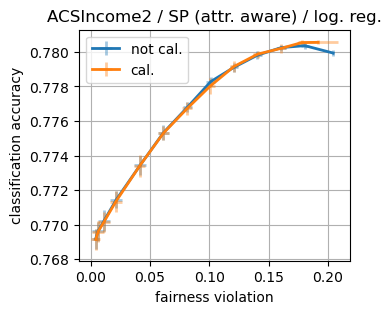

Results for attribute aware (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.779939  0.000162  0.204323  0.000608
0.180  0.780367  0.000173  0.180481  0.003210
0.160  0.780254  0.000175  0.160653  0.003628
0.140  0.779813  0.000240  0.140561  0.003478
0.120  0.779109  0.000258  0.120769  0.003175
0.100  0.778286  0.000253  0.101285  0.003613
0.080  0.776794  0.000301  0.081553  0.004010
0.060  0.775318  0.000432  0.061342  0.004814
0.040  0.773436  0.000542  0.041726  0.004830
0.020  0.771428  0.000495  0.021503  0.004873
0.010  0.770230  0.000617  0.011415  0.005076
0.005  0.769616  0.000542  0.006265  0.005219
0.001  0.769174  0.000589  0.004292  0.003159

Results for attribute aware (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.780559  0.000123  0.191627  0.016935
0.180  0.780545  0.000125  0.178034  0.003818
0.160  0.780211  0.000243  0.160590  0.003746
0.140  0.779874  0.000204  0.140782  0.003670
0.120  0.779159  0.000302  0.120867  0.003686
0.100  0.778036  0.000457  0.100984  0.004033
0.080  0.776725  0.000352  0.081371  0.004354
0.060  0.775303  0.000405  0.061431  0.004438
0.040  0.773393  0.000643  0.041300  0.004842
0.020  0.771328  0.000592  0.021228  0.004963
0.010  0.770157  0.000594  0.011260  0.005107
0.005  0.769597  0.000587  0.006376  0.005187
0.001  0.769137  0.000625  0.004312  0.003569

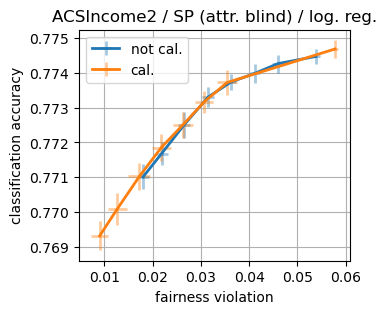

Results for attribute blind (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.774478  0.000212  0.053829  0.000802
0.030  0.774273  0.000259  0.045974  0.001147
0.025  0.773991  0.000267  0.041160  0.001068
0.020  0.773743  0.000220  0.036244  0.001034
0.015  0.773309  0.000288  0.031509  0.001259
0.010  0.772507  0.000366  0.026515  0.001198
0.005  0.771679  0.000335  0.021853  0.001272
0.001  0.771009  0.000361  0.018020  0.001140

Results for attribute blind (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.774694  0.000253  0.057801  0.000637
0.030  0.773729  0.000357  0.035451  0.002039
0.025  0.773178  0.000314  0.030733  0.001868
0.020  0.772507  0.000376  0.026260  0.002059
0.015  0.771852  0.000386  0.021783  0.001969
0.010  0.771019  0.000403  0.017230  0.002254
0.005  0.770084  0.000453  0.012664  0.001954
0.001  0.769308  0.000414  0.009011  0.001694

In [7]:
## Post-processing for statistical parity
criterion = 'sp'
criterion_name = 'SP'
alphas_aware = [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
                0.01, 0.005, 0.001]
alphas_blind = [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

  0%|                                                    | 0/65 [00:00<?, ?it/s]

 49%|████████████████████▋                     | 32/65 [00:00<00:00, 283.48it/s]

 98%|█████████████████████████████████████████▎| 64/65 [00:00<00:00, 226.60it/s]

100%|██████████████████████████████████████████| 65/65 [00:00<00:00, 236.34it/s]

  0%|                                                    | 0/65 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████▎| 64/65 [00:00<00:00, 432.93it/s]

100%|██████████████████████████████████████████| 65/65 [00:00<00:00, 422.05it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 4210.51it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

 80%|█████████████████████████████████▌        | 32/40 [00:00<00:00, 263.62it/s]

100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 313.75it/s]

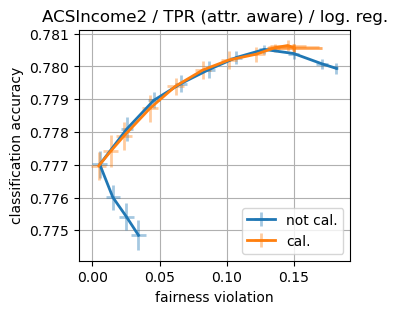

Results for attribute aware (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.779939  0.000162   0.181835  0.001177
0.200  0.780078  0.000144   0.171148  0.004321
0.180  0.780394  0.000176   0.149882  0.003930
0.160  0.780518  0.000145   0.128125  0.004306
0.140  0.780272  0.000203   0.107102  0.004567
0.120  0.779903  0.000264   0.086715  0.004337
0.100  0.779478  0.000257   0.065895  0.004221
0.080  0.778966  0.000244   0.045707  0.004647
0.060  0.778090  0.000357   0.025572  0.004663
0.040  0.777008  0.000422   0.005483  0.005595
0.020  0.776008  0.000381   0.015164  0.005295
0.010  0.775417  0.000419   0.025259  0.005734
0.001  0.774849  0.000457   0.034298  0.005896

Results for attribute aware (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.780559  0.000123   0.150516  0.020206
0.200  0.780561  0.000124   0.150487  0.020241
0.180  0.780579  0.000115   0.149621  0.018819
0.160  0.780638  0.000162   0.145466  0.013416
0.140  0.780574  0.000121   0.136319  0.003683
0.120  0.780373  0.000227   0.121945  0.006405
0.100  0.780197  0.000276   0.101697  0.005740
0.080  0.779890  0.000284   0.082189  0.005980
0.060  0.779398  0.000263   0.061923  0.006149
0.040  0.778720  0.000410   0.042793  0.006217
0.020  0.777870  0.000426   0.023280  0.005949
0.010  0.777408  0.000488   0.013483  0.005898
0.001  0.776968  0.000425   0.004722  0.005435

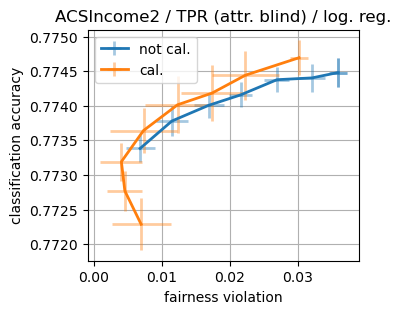

Results for attribute blind (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.774478  0.000212   0.035940  0.001269
0.030  0.774480  0.000210   0.035900  0.001325
0.025  0.774402  0.000207   0.032094  0.001955
0.020  0.774376  0.000177   0.026933  0.001839
0.015  0.774157  0.000182   0.021595  0.001691
0.010  0.774006  0.000183   0.016894  0.002218
0.005  0.773780  0.000211   0.011491  0.002395
0.001  0.773383  0.000194   0.006816  0.002122

Results for attribute blind (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.774694  0.000253   0.030179  0.001367
0.030  0.774441  0.000354   0.022293  0.004955
0.025  0.774182  0.000400   0.017383  0.004538
0.020  0.774014  0.000409   0.012318  0.004748
0.015  0.773642  0.000329   0.007317  0.004969
0.010  0.773192  0.000275   0.004063  0.003091
0.005  0.772769  0.000290   0.004574  0.002566
0.001  0.772288  0.000375   0.006963  0.004329

In [8]:
## Post-processing for equal opportunity
criterion = 'eopp'
criterion_name = 'TPR'
alphas_aware = [np.inf, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
                0.02, 0.01, 0.001]
alphas_blind = [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

  0%|                                                    | 0/65 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████▎| 64/65 [00:00<00:00, 417.03it/s]

100%|██████████████████████████████████████████| 65/65 [00:00<00:00, 419.73it/s]

  0%|                                                    | 0/65 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████▎| 64/65 [00:00<00:00, 450.54it/s]

100%|██████████████████████████████████████████| 65/65 [00:00<00:00, 453.50it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|                                                    | 0/40 [00:00<?, ?it/s]

 80%|██████████████████████████████████▍        | 32/40 [00:00<00:00, 38.65it/s]

100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.69it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|                                                    | 0/40 [00:00<?, ?it/s]

 80%|█████████████████████████████████▌        | 32/40 [00:00<00:00, 114.04it/s]

100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 139.64it/s]

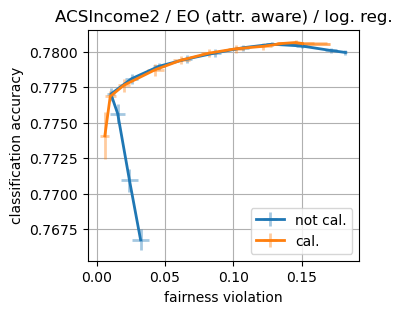

Results for attribute aware (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.779939  0.000162  0.181835  0.001177
0.200  0.780078  0.000144  0.171148  0.004321
0.180  0.780394  0.000176  0.149882  0.003930
0.160  0.780518  0.000145  0.128125  0.004306
0.140  0.780272  0.000203  0.107102  0.004567
0.120  0.779903  0.000264  0.086715  0.004337
0.100  0.779478  0.000257  0.065895  0.004221
0.080  0.778966  0.000244  0.045707  0.004647
0.060  0.778090  0.000357  0.025572  0.004663
0.040  0.777008  0.000422  0.010486  0.002680
0.020  0.775632  0.000662  0.015419  0.005405
0.010  0.770943  0.000811  0.024029  0.006154
0.001  0.766742  0.000732  0.032167  0.006251

Results for attribute aware (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.780559  0.000123  0.150516  0.020206
0.200  0.780561  0.000124  0.150487  0.020241
0.180  0.780579  0.000115  0.149621  0.018819
0.160  0.780638  0.000162  0.145466  0.013416
0.140  0.780574  0.000121  0.136319  0.003683
0.120  0.780373  0.000227  0.121945  0.006405
0.100  0.780197  0.000276  0.101697  0.005740
0.080  0.779890  0.000284  0.082189  0.005980
0.060  0.779398  0.000263  0.061923  0.006149
0.040  0.778720  0.000410  0.042793  0.006217
0.020  0.777632  0.000447  0.020020  0.004558
0.010  0.776846  0.000350  0.009988  0.004068
0.001  0.774069  0.001644  0.006056  0.003292

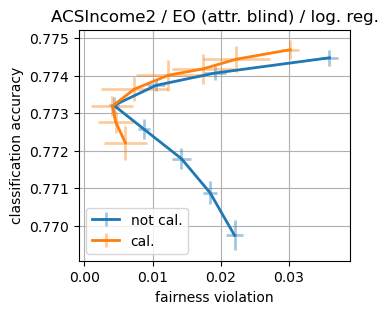

Results for attribute blind (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.774478  0.000212  0.035940  0.001269
0.030  0.774070  0.000186  0.019117  0.001634
0.025  0.773743  0.000161  0.010522  0.001354
0.020  0.773209  0.000221  0.004325  0.000782
0.015  0.772574  0.000271  0.008727  0.000824
0.010  0.771787  0.000276  0.014229  0.001388
0.005  0.770878  0.000307  0.018432  0.001082
0.001  0.769743  0.000398  0.022015  0.001236

Results for attribute blind (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.774694  0.000253  0.030179  0.001367
0.030  0.774441  0.000354  0.022293  0.004955
0.025  0.774182  0.000400  0.017383  0.004538
0.020  0.774014  0.000409  0.012318  0.004748
0.015  0.773642  0.000329  0.007328  0.004954
0.010  0.773192  0.000275  0.004109  0.003076
0.005  0.772769  0.000290  0.004574  0.002566
0.001  0.772213  0.000459  0.005997  0.003185

In [9]:
## Post-processing for equalized odds
criterion = 'eo'
criterion_name = 'EO'
alphas_aware = [np.inf, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
                0.02, 0.01, 0.001]
alphas_blind = [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

## Gradient boosting decision tree

In [10]:
model_name = 'GBDT'

# Train attribute aware p(Y | X, A) predictor
predictor_y = lightgbm.LGBMClassifier(random_state=seed_pretrain, verbosity=0)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute blind p(A, Y | X) predictor
predictor_u_ay = lightgbm.LGBMClassifier(random_state=seed_pretrain,
                                         verbosity=0)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print('Binned ECE of attribute aware predictor:',
      utils.calibration_error(predictor_y.predict_proba(inputs_), labels_))
print(
    'Binned ECE of attribute blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_))

Binned ECE of attribute aware predictor: 0.02543656502955001


Binned ECE of attribute blind predictor: 0.13074037905779953


In [11]:
# Precompute P(A, Y | X, A) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'p_ay_x': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'p_ay_x': probas_ay_u_}

  0%|                                                    | 0/60 [00:00<?, ?it/s]

 53%|██████████████████████▉                    | 32/60 [00:00<00:00, 76.15it/s]

100%|██████████████████████████████████████████| 60/60 [00:00<00:00, 139.28it/s]

  0%|                                                    | 0/60 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 60/60 [00:00<00:00, 7421.36it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 13524.56it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 4350.94it/s]

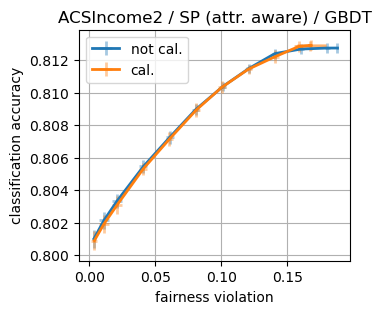

Results for attribute aware (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.812750  0.000308  0.187952  0.000441
0.180  0.812749  0.000300  0.180157  0.001909
0.160  0.812689  0.000302  0.160288  0.002580
0.140  0.812408  0.000302  0.140489  0.002330
0.120  0.811494  0.000265  0.120841  0.002546
0.100  0.810371  0.000281  0.100903  0.002308
0.080  0.808968  0.000339  0.080571  0.002671
0.060  0.807253  0.000397  0.060815  0.002945
0.040  0.805463  0.000423  0.040936  0.003054
0.020  0.803351  0.000439  0.021081  0.003604
0.010  0.802147  0.000543  0.011025  0.003711
0.001  0.801015  0.000543  0.003456  0.001885

Results for attribute aware (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.812896  0.000314  0.167348  0.011829
0.180  0.812917  0.000314  0.168173  0.011071
0.160  0.812846  0.000334  0.158644  0.003506
0.140  0.812214  0.000412  0.140526  0.002740
0.120  0.811455  0.000274  0.120573  0.002777
0.100  0.810342  0.000370  0.100392  0.002751
0.080  0.808939  0.000405  0.080912  0.002798
0.060  0.807147  0.000413  0.060584  0.002382
0.040  0.805304  0.000376  0.040655  0.002923
0.020  0.803094  0.000561  0.020966  0.003542
0.010  0.801922  0.000576  0.010992  0.003559
0.001  0.800905  0.000597  0.003753  0.002197

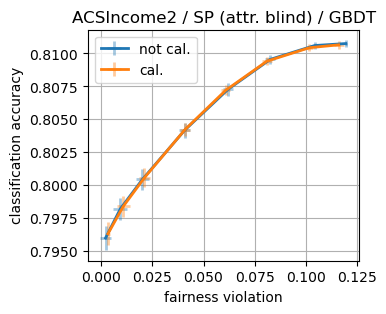

Results for attribute blind (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.810754  0.000253  0.119561  0.000548
0.100  0.810606  0.000266  0.104364  0.002247
0.080  0.809556  0.000332  0.082660  0.002477
0.060  0.807275  0.000467  0.061944  0.002500
0.040  0.804189  0.000566  0.040861  0.002710
0.020  0.800450  0.000777  0.020147  0.003045
0.010  0.798212  0.000838  0.009337  0.003396
0.001  0.795996  0.000925  0.002096  0.002528

Results for attribute blind (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.810656  0.000308  0.116046  0.002490
0.100  0.810441  0.000286  0.101799  0.001627
0.080  0.809417  0.000309  0.080983  0.002282
0.060  0.807209  0.000373  0.060856  0.002074
0.040  0.804230  0.000493  0.040964  0.002616
0.020  0.800576  0.000709  0.021129  0.002772
0.010  0.798404  0.000797  0.010773  0.003151
0.001  0.796317  0.000877  0.003273  0.000811

In [12]:
## Post-processing for statistical parity
criterion = 'sp'
criterion_name = 'SP'
alphas_aware = [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
                0.01, 0.001]
alphas_blind = [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

  0%|                                                    | 0/55 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 55/55 [00:00<00:00, 11449.04it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|                                                    | 0/55 [00:00<?, ?it/s]

 58%|████████████████████████▍                 | 32/55 [00:00<00:00, 155.67it/s]

100%|██████████████████████████████████████████| 55/55 [00:00<00:00, 255.77it/s]

  0%|                                                    | 0/30 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 30/30 [00:00<00:00, 39150.32it/s]

  0%|                                                    | 0/30 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 30/30 [00:00<00:00, 26225.33it/s]

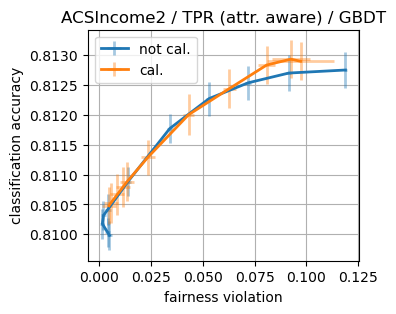

Results for attribute aware (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.812750  0.000308   0.118865  0.000739
0.100  0.812699  0.000301   0.091503  0.001217
0.080  0.812535  0.000279   0.071882  0.001309
0.060  0.812272  0.000284   0.053009  0.001439
0.040  0.811770  0.000247   0.033990  0.001469
0.020  0.810881  0.000246   0.013764  0.001443
0.010  0.810414  0.000258   0.004002  0.001409
0.008  0.810316  0.000240   0.001971  0.001316
0.005  0.810177  0.000248   0.001437  0.000960
0.002  0.810034  0.000242   0.003977  0.001383
0.001  0.809983  0.000248   0.004863  0.001342

Results for attribute aware (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.812896  0.000314   0.097181  0.016322
0.100  0.812931  0.000317   0.092489  0.009238
0.080  0.812833  0.000319   0.080837  0.004053
0.060  0.812439  0.000330   0.062822  0.002980
0.040  0.812002  0.000344   0.043111  0.002585
0.020  0.811287  0.000296   0.023351  0.003346
0.010  0.810883  0.000323   0.013451  0.003322
0.008  0.810796  0.000339   0.011503  0.003364
0.005  0.810667  0.000349   0.008681  0.003373
0.002  0.810524  0.000335   0.005547  0.003539
0.001  0.810480  0.000313   0.004669  0.003374

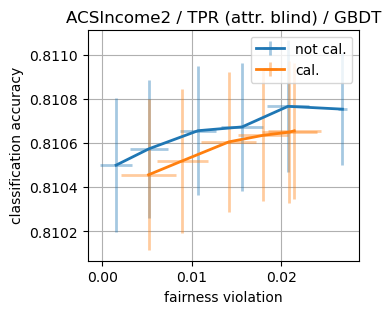

Results for attribute blind (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.810754  0.000253   0.026850  0.000505
0.020  0.810767  0.000300   0.020758  0.002344
0.015  0.810674  0.000292   0.015622  0.002348
0.010  0.810657  0.000294   0.010690  0.002007
0.005  0.810575  0.000312   0.005224  0.002142
0.001  0.810500  0.000303   0.001527  0.001762

Results for attribute blind (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.810656  0.000308   0.021463  0.002985
0.020  0.810650  0.000322   0.020918  0.003076
0.015  0.810636  0.000299   0.017989  0.002793
0.010  0.810606  0.000317   0.014156  0.003077
0.005  0.810520  0.000328   0.008919  0.002850
0.001  0.810457  0.000342   0.005157  0.003091

In [13]:
## Post-processing for equal opportunity
criterion = 'eopp'
criterion_name = 'TPR'
alphas_aware = [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.005, 0.002,
                0.001]
alphas_blind = [np.inf, 0.02, 0.015, 0.01, 0.005, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

  0%|                                                    | 0/55 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 6380.14it/s]

  0%|                                                    | 0/55 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 55/55 [00:00<00:00, 15711.14it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|                                                    | 0/35 [00:00<?, ?it/s]

 91%|███████████████████████████████████████▎   | 32/35 [00:00<00:00, 36.26it/s]

100%|███████████████████████████████████████████| 35/35 [00:00<00:00, 39.41it/s]

  0%|                                                    | 0/35 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 35/35 [00:00<00:00, 386.32it/s]

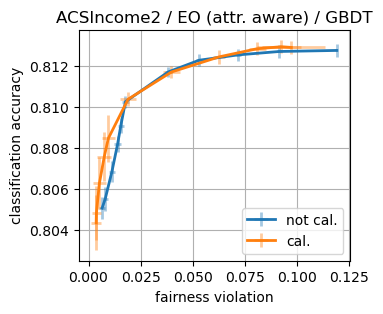

Results for attribute aware (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.812750  0.000308  0.118865  0.000739
0.100  0.812699  0.000301  0.091503  0.001217
0.080  0.812535  0.000279  0.071882  0.001309
0.060  0.812272  0.000284  0.053009  0.001439
0.040  0.811700  0.000231  0.038174  0.001607
0.020  0.810248  0.000284  0.017708  0.001746
0.010  0.809083  0.000363  0.015486  0.001395
0.008  0.808200  0.000398  0.013978  0.001575
0.005  0.806843  0.000508  0.011228  0.001418
0.002  0.805512  0.000584  0.008020  0.001299
0.001  0.805061  0.000540  0.006521  0.001262

Results for attribute aware (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.812896  0.000314  0.097181  0.016322
0.100  0.812931  0.000317  0.092489  0.009238
0.080  0.812833  0.000319  0.080837  0.004053
0.060  0.812438  0.000331  0.062684  0.002910
0.040  0.811697  0.000294  0.039765  0.004014
0.020  0.810369  0.000346  0.018947  0.003660
0.010  0.808459  0.001151  0.009496  0.003224
0.008  0.807569  0.001191  0.007554  0.003322
0.005  0.806263  0.001273  0.005201  0.003072
0.002  0.804811  0.001329  0.003777  0.002170
0.001  0.804350  0.001348  0.003671  0.002246

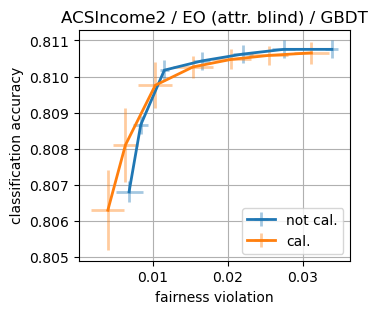

Results for attribute blind (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.810754  0.000253  0.033849  0.000847
0.025  0.810754  0.000250  0.027453  0.001525
0.020  0.810623  0.000251  0.021968  0.001336
0.015  0.810434  0.000261  0.016535  0.001152
0.010  0.810178  0.000295  0.011544  0.000588
0.005  0.808659  0.000255  0.008397  0.001004
0.001  0.806808  0.000284  0.006847  0.001810

Results for attribute blind (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.810656  0.000308  0.031133  0.002288
0.025  0.810587  0.000272  0.025451  0.002616
0.020  0.810476  0.000275  0.020463  0.002576
0.015  0.810269  0.000309  0.015381  0.002660
0.010  0.809758  0.000643  0.010338  0.002253
0.005  0.808101  0.001017  0.006357  0.001692
0.001  0.806296  0.001110  0.004018  0.002181

In [14]:
## Post-processing for equalized odds
criterion = 'eo'
criterion_name = 'EO'
alphas_aware = [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.005, 0.002,
                0.001]
alphas_blind = [np.inf, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

## ReLU network

In [15]:
model_name = 'MLP'

# Train attribute aware p(Y | X, A) predictor
predictor_y = MLPClassifier(hidden_layer_sizes=(500, 200, 100),
                            activation=torch.nn.ReLU(),
                            n_classes=n_classes,
                            n_epochs=20,
                            batch_size=128,
                            lr=1e-3,
                            gamma=0.8,
                            device=device,
                            random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute blind p(A, Y | X) predictor
predictor_u_ay = MLPClassifier(hidden_layer_sizes=(500, 200, 100),
                               activation=torch.nn.ReLU(),
                               n_classes=n_groups * n_classes,
                               n_epochs=20,
                               batch_size=128,
                               lr=1e-3,
                               gamma=0.8,
                               device=device,
                               random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print('Binned ECE of attribute aware predictor:',
      utils.calibration_error(predictor_y.predict_proba(inputs_), labels_))
print(
    'Binned ECE of attribute blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_))

Binned ECE of attribute aware predictor: 0.019196826910389233


Binned ECE of attribute blind predictor: 0.12583378509003848


In [16]:
# Precompute P(A, Y | X, A) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'p_ay_x': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'p_ay_x': probas_ay_u_}

  0%|                                                    | 0/65 [00:00<?, ?it/s]

 49%|█████████████████████▏                     | 32/65 [00:02<00:03, 10.98it/s]

100%|███████████████████████████████████████████| 65/65 [00:02<00:00, 22.19it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|                                                    | 0/65 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████▎| 64/65 [00:00<00:00, 574.31it/s]

100%|██████████████████████████████████████████| 65/65 [00:00<00:00, 574.26it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|                                                    | 0/45 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 45/45 [00:00<00:00, 15175.98it/s]

  0%|                                                    | 0/45 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 45/45 [00:00<00:00, 11831.23it/s]

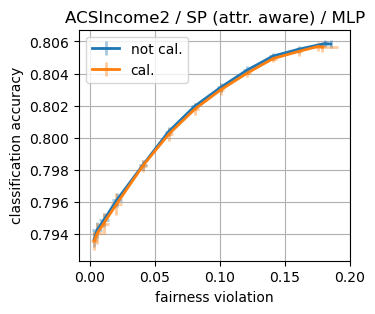

Results for attribute aware (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.805841  0.000222  0.185219  0.000395
0.180  0.805872  0.000206  0.180810  0.002194
0.160  0.805521  0.000210  0.160926  0.002634
0.140  0.805087  0.000218  0.140750  0.002985
0.120  0.804204  0.000254  0.120788  0.002963
0.100  0.803154  0.000284  0.100929  0.003019
0.080  0.801961  0.000207  0.080700  0.003021
0.060  0.800371  0.000266  0.060562  0.002970
0.040  0.798285  0.000342  0.040832  0.003092
0.020  0.796097  0.000455  0.020755  0.003836
0.010  0.794869  0.000451  0.010887  0.003794
0.005  0.794211  0.000506  0.005594  0.003840
0.001  0.793664  0.000518  0.003501  0.001813

Results for attribute aware (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.805644  0.000317  0.178862  0.012013
0.180  0.805693  0.000286  0.175450  0.005550
0.160  0.805383  0.000293  0.160818  0.002541
0.140  0.804935  0.000233  0.140988  0.002795
0.120  0.804026  0.000243  0.121028  0.002743
0.100  0.802985  0.000334  0.100657  0.002747
0.080  0.801786  0.000402  0.080864  0.002866
0.060  0.800201  0.000384  0.060550  0.003046
0.040  0.798242  0.000382  0.040810  0.002988
0.020  0.795837  0.000685  0.020464  0.003893
0.010  0.794627  0.000659  0.010575  0.003875
0.005  0.794028  0.000648  0.005737  0.003556
0.001  0.793547  0.000581  0.003348  0.002077

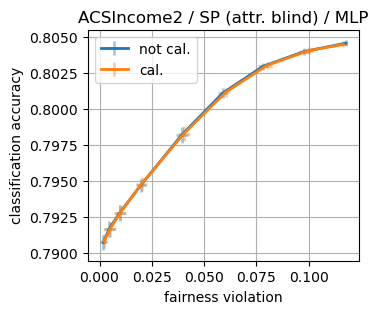

Results for attribute blind (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.804561  0.000207  0.117689  0.000559
0.100  0.803982  0.000264  0.097742  0.002176
0.080  0.802951  0.000237  0.078058  0.002268
0.060  0.801092  0.000344  0.058843  0.002275
0.040  0.798212  0.000559  0.039391  0.002754
0.020  0.794699  0.000448  0.019732  0.002431
0.010  0.792783  0.000533  0.009651  0.002411
0.005  0.791671  0.000562  0.004638  0.002539
0.001  0.790730  0.000538  0.001890  0.001495

Results for attribute blind (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.804477  0.000214  0.116537  0.001549
0.100  0.804050  0.000271  0.099955  0.002134
0.080  0.803010  0.000235  0.079916  0.002308
0.060  0.801158  0.000316  0.060310  0.002191
0.040  0.798289  0.000490  0.040351  0.002878
0.020  0.794810  0.000495  0.020162  0.002669
0.010  0.792801  0.000544  0.009925  0.002887
0.005  0.791656  0.000518  0.004995  0.002711
0.001  0.790803  0.000483  0.002133  0.001268

In [17]:
## Post-processing for statistical parity
criterion = 'sp'
criterion_name = 'SP'
alphas_aware = [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
                0.01, 0.005, 0.001]
alphas_blind = [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.005, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

  0%|                                                    | 0/45 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 45/45 [00:00<00:00, 12046.44it/s]

  0%|                                                    | 0/45 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 8957.93it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 40/40 [00:00<00:00, 408.91it/s]

  0%|                                                    | 0/40 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 22127.69it/s]

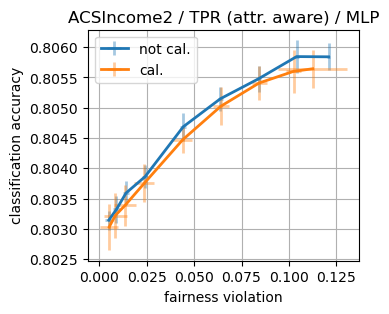

Results for attribute aware (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.805841  0.000222   0.120918  0.000721
0.100  0.805845  0.000270   0.104034  0.001410
0.080  0.805478  0.000211   0.083967  0.001272
0.060  0.805149  0.000200   0.063863  0.001245
0.040  0.804686  0.000233   0.044265  0.001544
0.020  0.803861  0.000195   0.024101  0.001624
0.010  0.803590  0.000201   0.014050  0.001768
0.005  0.803319  0.000216   0.008989  0.001855
0.001  0.803143  0.000155   0.004981  0.001957

Results for attribute aware (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.805644  0.000317   0.112545  0.018069
0.100  0.805600  0.000352   0.102444  0.004026
0.080  0.805409  0.000277   0.084295  0.003958
0.060  0.805025  0.000311   0.064112  0.004238
0.040  0.804471  0.000212   0.043953  0.004862
0.020  0.803751  0.000316   0.023664  0.005363
0.010  0.803387  0.000344   0.013560  0.005689
0.005  0.803219  0.000378   0.008406  0.005941
0.001  0.803030  0.000384   0.005198  0.004673

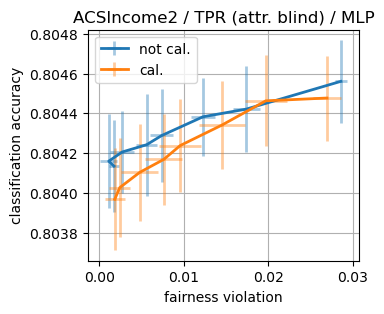

Results for attribute blind (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.804561  0.000207   0.028576  0.000732
0.020  0.804421  0.000216   0.017390  0.001585
0.015  0.804383  0.000195   0.012271  0.001442
0.010  0.804289  0.000234   0.007389  0.001366
0.008  0.804242  0.000257   0.005593  0.001268
0.005  0.804206  0.000208   0.002707  0.001430
0.002  0.804160  0.000237   0.001115  0.000995
0.001  0.804135  0.000233   0.001726  0.000610

Results for attribute blind (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.804477  0.000214   0.026934  0.001690
0.020  0.804463  0.000229   0.019703  0.002485
0.015  0.804341  0.000222   0.014497  0.002694
0.010  0.804238  0.000232   0.009575  0.002478
0.008  0.804168  0.000229   0.007612  0.002169
0.005  0.804103  0.000242   0.004775  0.002213
0.002  0.804027  0.000248   0.002415  0.001244
0.001  0.803968  0.000256   0.001827  0.001157

In [18]:
## Post-processing for equal opportunity
criterion = 'eopp'
criterion_name = 'TPR'
alphas_aware = [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.005, 0.001]
alphas_blind = [np.inf, 0.02, 0.015, 0.01, 0.008, 0.005, 0.002, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

  0%|                                                    | 0/45 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 498.92it/s]

  0%|                                                    | 0/45 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 45/45 [00:00<00:00, 22108.90it/s]

  0%|                                                    | 0/50 [00:00<?, ?it/s]

 64%|███████████████████████████▌               | 32/50 [00:00<00:00, 34.66it/s]

100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 53.91it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|                                                    | 0/50 [00:00<?, ?it/s]

 64%|███████████████████████████▌               | 32/50 [00:00<00:00, 79.35it/s]

100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 122.66it/s]

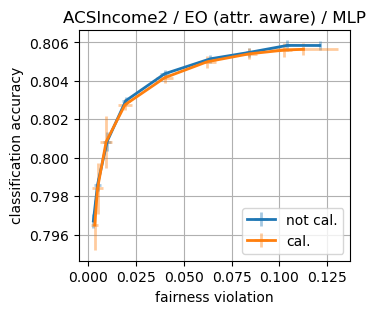

Results for attribute aware (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.805841  0.000222  0.120918  0.000721
0.100  0.805845  0.000270  0.104034  0.001410
0.080  0.805478  0.000211  0.083967  0.001272
0.060  0.805149  0.000200  0.063863  0.001245
0.040  0.804372  0.000199  0.040025  0.002355
0.020  0.802969  0.000208  0.019678  0.002120
0.010  0.800846  0.000513  0.009927  0.002227
0.005  0.798611  0.000338  0.004951  0.001828
0.001  0.796726  0.000363  0.002760  0.000502

Results for attribute aware (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.805644  0.000317  0.112545  0.018069
0.100  0.805600  0.000352  0.102444  0.004026
0.080  0.805409  0.000277  0.084295  0.003958
0.060  0.804996  0.000315  0.062229  0.004599
0.040  0.804166  0.000270  0.040042  0.004394
0.020  0.802757  0.000293  0.019272  0.003598
0.010  0.800831  0.001342  0.009405  0.003097
0.005  0.798411  0.001338  0.004932  0.002639
0.001  0.796511  0.001315  0.003462  0.001692

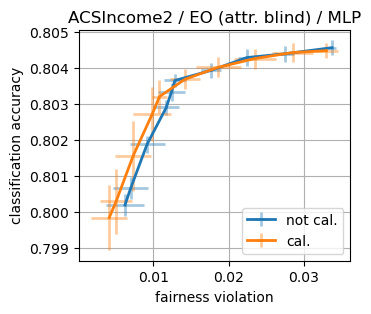

Results for attribute blind (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.804561  0.000207  0.033710  0.000582
0.030  0.804389  0.000227  0.027440  0.001249
0.025  0.804286  0.000234  0.022411  0.001221
0.020  0.803930  0.000215  0.017689  0.001311
0.015  0.803648  0.000188  0.012880  0.001510
0.010  0.803338  0.000247  0.012429  0.001844
0.008  0.802901  0.000216  0.011739  0.001721
0.005  0.801876  0.000231  0.009190  0.002322
0.002  0.800652  0.000302  0.007009  0.002317
0.001  0.800187  0.000295  0.006262  0.002483

Results for attribute blind (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.804477  0.000214  0.032974  0.001540
0.030  0.804425  0.000259  0.028486  0.002717
0.025  0.804257  0.000277  0.023470  0.002751
0.020  0.804014  0.000275  0.018626  0.002962
0.015  0.803682  0.000282  0.014211  0.001994
0.010  0.803201  0.000462  0.010832  0.000934
0.008  0.802717  0.000747  0.009876  0.002522
0.005  0.801552  0.000980  0.007337  0.002382
0.002  0.800289  0.000906  0.005085  0.002163
0.001  0.799837  0.000909  0.004172  0.002357

In [19]:
## Post-processing for equalized odds
criterion = 'eo'
criterion_name = 'EO'
alphas_aware = [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.005, 0.001]
alphas_blind = [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.008, 0.005, 0.002,
                0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)